In [1]:
import sys
sys.path.append("../src")

In [2]:
from typing import List
from typing import Tuple

import tempfile
from pathlib import Path

import torch
from IPython.display import display
from IPython.display import Markdown

from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import textwrap

from health_multimodal.common.visualization import plot_phrase_grounding_similarity_map
from health_multimodal.text import get_bert_inference
from health_multimodal.text.utils import BertEncoderType
from health_multimodal.image import get_image_inference
from health_multimodal.image.utils import ImageModelType
from health_multimodal.vlp import ImageTextInferenceEngine

/home/vboxuser/.pyenv/versions/3.10.13/envs/ac215env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load BioViL model

# Load df

In [3]:
dir_name="../../../train"
df = pd.read_csv("../../../label_1024_split.csv")
print(len(df))
df_train = df.query('split == "train"')
df.head()

1448


,dicom_id,category_name,label_text,path,x,y,w,h,image_width,image_height,split
0,675d792f-a3521e48-5eec8573-1e81d644-e60c34f8,Pneumonia,Bibasilar opacities,files/p10/p10233088/s54276838/675d792f-a3521e4...,113,575,308,159,1024,1024,train
1,675d792f-a3521e48-5eec8573-1e81d644-e60c34f8,Pneumonia,Bibasilar opacities,files/p10/p10233088/s54276838/675d792f-a3521e4...,584,574,284,177,1024,1024,train
2,5318d353-daae9c3d-2ee8648e-32b65198-aeff801e,Pneumonia,Bilateral multifocal areas of consolidation,files/p10/p10123147/s50230934/5318d353-daae9c3...,608,425,304,267,1024,1024,val
3,5318d353-daae9c3d-2ee8648e-32b65198-aeff801e,Pneumonia,Bilateral multifocal areas of consolidation,files/p10/p10123147/s50230934/5318d353-daae9c3...,183,231,256,224,1024,1024,val
4,4decce85-c6ede74e-7a8bc81c-e81edee9-5ec17116,Pneumothorax,Large right-sided pneumothorax,files/p10/p10500801/s58577720/4decce85-c6ede74...,88,36,294,884,1024,1024,test


In [4]:
df["split"].value_counts()

split
train    948
val      321
test     179
Name: count, dtype: int64

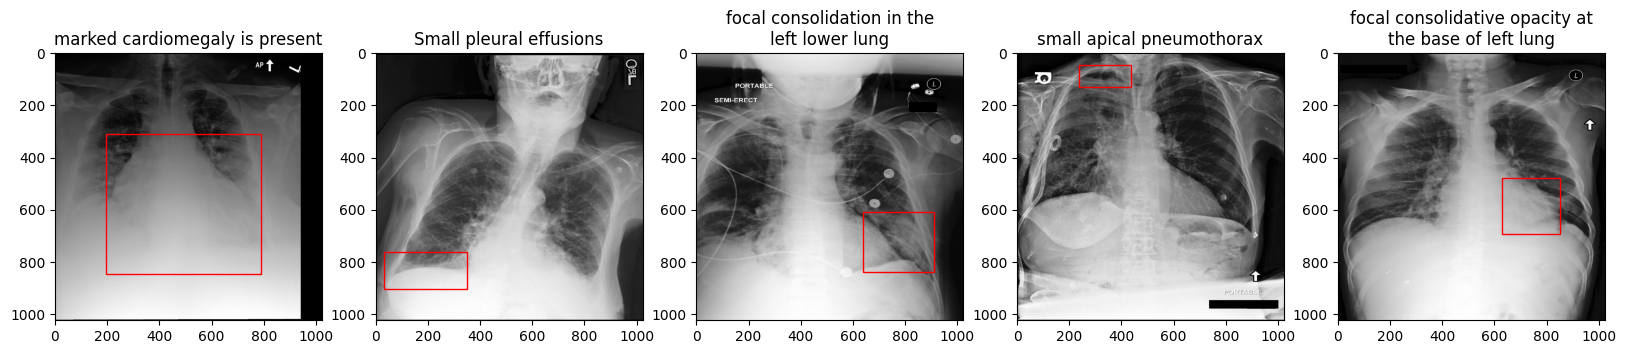

In [5]:
df_sample = df_train.sample(5, random_state=42)
fig = plt.figure(figsize=(20, 10))

for i, row in enumerate(df_sample.itertuples()):
    img_path = f"{dir_name}/{row.dicom_id }.jpg"
    img = Image.open(img_path)
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(np.array(img), cmap='gray')
    rect = patches.Rectangle((row.x, row.y), row.w, row.h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # ax.set_title(row.label_text)

    wrapper = textwrap.TextWrapper(width=30)  # it will wrap the text at 30 characters
    word_list = wrapper.wrap(text=row.label_text)
    label_new = '\n'.join(word_list)
    ax.set_title(label_new)


plt.show()


## Training

In [6]:
# def plot_phrase_grounding(image_path: Path, text_prompt: str, bboxes: List[TypeBox]) -> None:
#     similarity_map = BioVLP.get_similarity_map_from_raw_data(
#         image_path=image_path,
#         query_text=text_prompt,
#         interpolation="bilinear",
#     )

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = f"{dir_name}/{row.dicom_id}.jpg"
        # image = Image.open(image_path).convert('RGB')
        # image = torch.tensor(np.array(image))
        text_prompt = row.label_text
        ground_truth_boxes = torch.tensor([row.x, row.y, row.w, row.h])

        return image_path, text_prompt, ground_truth_boxes

train_dataset = CustomDataset(df_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [8]:

# Load BioViL Model
text_inference = get_bert_inference(BertEncoderType.BIOVIL_T_BERT)
image_inference = get_image_inference(ImageModelType.BIOVIL_T)

BioViL = ImageTextInferenceEngine(
    image_inference_engine=image_inference,
    text_inference_engine=text_inference,
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.


Using downloaded and verified file: /tmp/biovil_t_image_model_proj_size_128.pt


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# train_loader = DataLoader(MyDataset(), batch_size=32, shuffle=True)

import torch.nn as nn

# class BoundingBoxPredictor(nn.Module):
#     def __init__(self, input_dim, hidden_dim=512):
#         super(BoundingBoxPredictor, self).__init__()

#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, 4)

#         self.relu = nn.ReLU()

#     def forward(self, similarity_map):
#         # print(similarity_map.shape)
#         # x = similarity_map.view(similarity_map.size(0), -1)
#         x = similarity_map.view(1, -1)

#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         coords = self.fc3(x)

#         return coords * 1024


# class CombinedModel(nn.Module):
#     def __init__(self, BioViL):
#         super(CombinedModel, self).__init__()
#         self.BioViL = BioViL
#         # self.box_predictor = box_predictor

#     def forward(self, image_path, text_prompt):
#         similarity_map = self.BioViL.get_similarity_map_from_raw_data(
#             image_path=image_path,
#             query_text=text_prompt,
#             interpolation="bilinear",
#         )

#         # bbox_coordinates = self.box_predictor(similarity_map)
        
#         return similarity_map


# bbox_predictor = BoundingBoxPredictor(input_dim=14*14)
# model = CombinedModel(BioViL)

criterion = nn.MSELoss()
optimizer = optim.Adam(BioViL.text_inference_engine.model.parameters(), lr=0.001)

n_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

for epoch in range(n_epochs):
    # model.train()
    
    for batch_idx, (image_path, text_prompt, ground_truth_boxes) in enumerate(train_loader):
        image_path = Path(image_path[0])
        text_prompt = text_prompt[0]
        ground_truth_boxes = ground_truth_boxes[0]

        # predicted_boxes = model(image_path, text_prompt)
        # print(predicted_boxes.cpu().detach().numpy())
        # print(ground_truth_boxes.cpu().detach().numpy())
        # loss = criterion(predicted_boxes, ground_truth_boxes.view(1, -1).float())
        # print(ground_truth_boxes)
        
        similarity_map = BioViL.get_similarity_map_from_raw_data(
            image_path=image_path,
            query_text=text_prompt,
            interpolation="bilinear",
        ).clip(0)
        assert similarity_map.shape[0] == 14
        assert similarity_map.shape[1] == 14


        row_x, row_y, row_w, row_h = (ground_truth_boxes * 14.0 / 1024.0).detach().int()

        # Calculate the sum within the box
        sum_val = torch.sum(similarity_map[row_x:row_x+row_w, row_y:row_y+row_h])
        loss = -sum_val / torch.sum(similarity_map)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 1 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")
    



Epoch 1/10, Batch 0/948, Loss: -0.13033564388751984
Epoch 1/10, Batch 1/948, Loss: -0.06935571134090424
Epoch 1/10, Batch 2/948, Loss: -0.139032244682312
Epoch 1/10, Batch 3/948, Loss: -0.16548725962638855
Epoch 1/10, Batch 4/948, Loss: -0.37491151690483093
Epoch 1/10, Batch 5/948, Loss: -0.010750158689916134
Epoch 1/10, Batch 6/948, Loss: -0.02626079134643078


KeyboardInterrupt: 